In [4]:
import numpy as np
import pandas as pd
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer


In [8]:
import pandas as pd
import numpy as np


file_path = "Datasets/VanilaDataset/PU results/"
trainDataset = pd.read_csv(file_path + 'train_PU_no_pattern_ohlc.csv', index_col=[0, 1])
testDataset = pd.read_csv(file_path + 'test_PU_no_pattern_ohlc.csv' , index_col=[0, 1])


In [10]:
# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Pattern'
series_length = 100  # Target series length for ROCKET

def adjust_series_length(group, target_length):

    series = group.values
    current_length = len(series)

    if current_length > target_length:
        return series[:target_length]
    else:
        # Padding with zeros if shorter
        padding = np.zeros((target_length - current_length, series.shape[1]))
        return np.vstack([series, padding])


def prepare_rocket_data(dataset, features, target, series_length):
    # Group by 'Instance' and adjust each series length
    adjusted = dataset.groupby(level=0).apply(
        lambda group: adjust_series_length(group[features], series_length)
    )
    
    # Stack adjusted arrays
    X = np.stack(adjusted.values)  # Shape: (num_samples, series_length, num_features)

    # Extract targets (one per instance)
    y = dataset.groupby(level=0)[target].first().values  # Shape: (num_samples,)
    
    X = np.transpose(X, (0, 2, 1)) # shape: (num_samples, num_features, series_length)

    return X, y

# Prepare training and testing data
X_train, y_train = prepare_rocket_data(trainDataset, features, target, series_length)
X_test, y_test = prepare_rocket_data(testDataset, features, target, series_length)

print(f"X_train shape: {X_train.shape}")  # Expect (7080, 5, 100)
print(f"y_train shape: {y_train.shape}")  # Expect (7080,)




X_train shape: (7306, 5, 100)
y_train shape: (7306,)


# Rocket With Logistic Regression


In [11]:
# from sktime.transformations.panel.rocket import Rocket
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sktime.datasets import load_unit_test  # Example dataset
# from sklearn.metrics import classification_report, accuracy_score

In [12]:
# rocket = Rocket(num_kernels=10000)
# clf = make_pipeline(rocket, LogisticRegression(max_iter=5000, multi_class='multinomial', solver='lbfgs'))


# print("Fitting the pipeline to the training dataset...")
# clf.fit(X_train, y_train)

In [13]:
# y_train_probs = clf.predict_proba(X_train)  # Training set probabilities
# y_test_probs = clf.predict_proba(X_test)

In [14]:
# y_test_probs

In [15]:
# y_train_probs

In [16]:
# from sklearn.metrics import accuracy_score

# # Training accuracy
# y_train_pred = y_train_probs.argmax(axis=1)  # Predicted classes for training data
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Training Accuracy: {train_accuracy:.2f}")

# # Testing accuracy
# y_test_pred = y_test_probs.argmax(axis=1)  # Predicted classes for test data
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy: {test_accuracy:.2f}")


In [17]:
model_stats = {}

# Rocket With XGBoost


In [18]:
X_train = trainDataset.drop(columns=['Pattern'])
y_train = trainDataset.groupby(level=0)['Pattern'].first().to_frame()
X_test = testDataset.drop(columns=['Pattern'])
y_test = testDataset.groupby(level=0)['Pattern'].first().to_frame()

In [19]:
y_train

,Pattern
Instance,
0,0
1,0
2,2
3,2
4,2
...,...
7301,8
7302,8
7303,8


In [20]:
X_train

Open      High       Low     Close    Volume
Instance Time                                                  
0        0     0.755760  1.000000  0.631336  0.645161  1.000000
         1     0.576037  0.576037  0.198157  0.211981  0.276309
         2     0.299539  0.341014  0.087558  0.184332  0.000000
         3     0.165899  0.239632  0.000000  0.184332  0.159668
         4     0.202765  0.350231  0.105991  0.267281  0.216174
...                 ...       ...       ...       ...       ...
7305     60    0.675079  0.760252  0.652997  0.744479  0.203040
         61    0.741325  0.817035  0.712934  0.794953  0.234626
         62    0.776025  0.817035  0.750789  0.817035  0.096385
         63    0.782334  0.804416  0.731861  0.772871  0.132083
         64    0.763407  0.776025  0.712934  0.769716  0.106083

[237480 rows x 5 columns]

In [21]:
# check X_train for inf values
print(X_train.isin([np.inf, -np.inf]).sum().sum())


0


In [22]:
# check X_train for nan values
print(X_train.isna().sum().sum())

# check for nan values in each column
print(X_train.isna().sum())

# cjheck which rows have nan values
print(X_train[X_train.isna().any(axis=1)])

0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Empty DataFrame
Columns: [Open, High, Low, Close, Volume]
Index: []


In [23]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(method='ffill', inplace=True)

C:\Users\gwiku\AppData\Local\Temp\ipykernel_42312\1959111549.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train.fillna(method='ffill', inplace=True)


In [24]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
import time
from xgboost import XGBClassifier


fl = FixedLengthTransformer(fixed_length=100, fill_value=0)
rocket = Rocket(num_kernels=10000)
xgbr = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    n_estimators=100,
    device="cuda"
)

# record the time taken to fit the model
start = time.time()
clf_xgb = make_pipeline(
    fl,
    rocket,
    xgbr
)
clf_xgb.fit(X_train, y_train)

end = time.time()
time_rocket_xgb = end - start

model_stats['rocket_xgb_train_time'] = time_rocket_xgb

clf_xgb

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('rocket', Rocket()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=N...None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [25]:
# from xgboost import XGBClassifier
# from sktime.transformations.panel.padder import PaddingTransformer

# padder = PaddingTransformer(pad_length=100, fill_value=0)
# rocket = Rocket(num_kernels=10000)


# clf_xgb = make_pipeline(
#     padder,
#     rocket,
#     XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
# )
# clf_xgb.fit(X_train, y_train)


In [26]:
X_test

Open      High       Low     Close    Volume
Instance Time                                                  
0        0     0.669468  1.000000  0.531279  0.859944  1.000000
         1     0.925304  0.957050  0.691877  0.902894  0.591858
         2     0.582633  0.634921  0.023343  0.316527  0.956003
         3     0.258637  0.954249  0.144724  0.772176  0.267765
         4     0.816994  0.968254  0.510738  0.591970  0.344355
...                 ...       ...       ...       ...       ...
625      59    0.424345  0.458725  0.396762  0.429143  0.048210
         60    0.403558  0.456526  0.389966  0.448531  0.065243
         61    0.444533  0.474515  0.424345  0.456526  0.029015
         62    0.452529  0.522886  0.444134  0.476514  0.058840
         63    0.494903  0.545673  0.486908  0.517290  0.110733

[19687 rows x 5 columns]

In [27]:
y_train_probs = clf_xgb.predict_proba(X_train) 
# record test time
start = time.time()
y_test_probs = clf_xgb.predict_proba(X_test)
end = time.time()
time_rocket_xgb_test = end - start
model_stats['rocket_xgb_test_time'] = time_rocket_xgb_test

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [28]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)

model_stats['rocket_xgb_test_accuracy'] = test_accuracy

print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.72


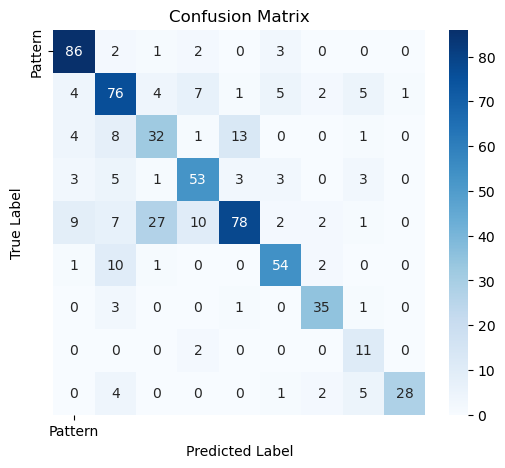

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [30]:
# save the pipelined model
import joblib
joblib.dump(clf_xgb, "rocket_model_w_aug_PU.pkl")

['rocket_model_w_aug.pkl']

In [31]:
import os
import joblib

model_save_dir = ''
pipeline = joblib.load(os.path.join(model_save_dir, "rocket_model_w_aug_PU.pkl"))
# predict on the subset of the test data


In [32]:
y_pred_test = clf_xgb.predict_proba(X_test)
y_pred_test

array([[6.2227659e-03, 4.0672565e-04, 3.3977516e-03, ..., 7.5216703e-05,
        1.4264823e-05, 1.5961316e-05],
       [4.2136078e-04, 3.4213517e-04, 5.0620634e-02, ..., 2.8339535e-04,
        2.9067514e-05, 3.2428114e-05],
       [1.6923947e-04, 3.0088378e-02, 1.9622110e-04, ..., 3.6599587e-05,
        3.4255943e-06, 5.6472959e-06],
       ...,
       [8.5282396e-04, 1.7341785e-01, 2.1199093e-03, ..., 2.6282698e-03,
        1.3817173e-01, 6.7203999e-01],
       [2.0616665e-02, 2.6397184e-01, 1.3564894e-03, ..., 1.9640387e-03,
        4.6698081e-01, 2.0922093e-02],
       [4.7034235e-03, 7.8135997e-01, 8.7069469e-03, ..., 3.7785750e-02,
        6.3284650e-02, 1.6933728e-02]], dtype=float32)

In [33]:
import numpy as np

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the class with the maximum probability for each sample
    max_probs = np.max(y_pred_test, axis=1)  # Maximum probability for each sample
    max_classes = np.argmax(y_pred_test, axis=1)  # Corresponding class for max probability
    
    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    return results


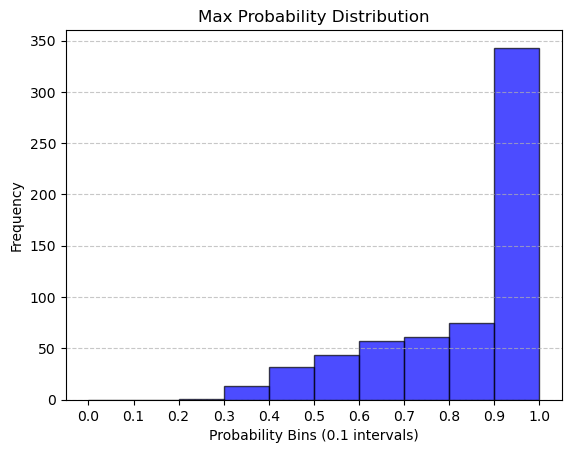

array([ 4,  4,  5,  2,  5,  3,  6,  0, -1,  1,  8,  4,  5,  4,  1,  2,  5,
        3,  7,  7,  5,  7,  0,  4,  4,  3,  0,  2,  4,  5,  3,  3,  4,  3,
        5,  6,  0,  4,  3,  3,  0,  0,  1,  5, -1,  0,  0,  2,  1,  1, -1,
        4,  5,  4,  1,  1,  1,  0,  3,  2,  6,  0,  1,  7,  1,  4,  0,  0,
        2,  3,  0,  6,  2,  3,  6,  6,  5,  5,  3,  0,  3, -1,  5, -1,  0,
        5,  6,  3,  5,  6,  5,  1,  4,  3,  1,  1,  0,  4,  1,  0,  1,  2,
        4,  2,  0,  4,  4,  4,  3,  6,  2,  0,  1,  1,  7,  7,  4,  1,  0,
        0,  0,  0,  0,  4,  0,  3,  4,  6,  3,  4,  5,  4,  0,  0,  2,  2,
        1, -1,  4,  6,  5,  0,  1,  2,  0, -1,  4,  1,  2,  0,  4,  1, -1,
        0,  1,  1,  1,  6,  0,  5,  7,  0,  5,  4,  7,  4,  4,  0,  2,  0,
        1,  0,  5,  0,  2,  2,  4,  3, -1,  1,  1,  0,  4,  4,  4, -1,  4,
        4,  1,  6,  2,  1,  3,  6,  3,  1,  1,  1,  3,  7,  2,  4,  1,  6,
        0,  3,  0,  3,  0,  7,  0,  5,  7,  3,  6,  3,  1,  4,  6,  3,  5,
        3, -1,  5,  0,  2

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the max probability for each sample
    max_probs = np.max(y_pred_test, axis=1)
    max_classes = np.argmax(y_pred_test, axis=1)  # Class with max probability

    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    # Plot a bar graph of max probabilities
    plot_max_probability_bar_graph(max_probs)
    
    return results

def plot_max_probability_bar_graph(max_probs):
    # Create bins for the probabilities (0.0 to 1.0 with a step of 0.1)
    bins = np.arange(0, 1.1, 0.1)
    
    # Plot the histogram
    plt.hist(max_probs, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Max Probability Distribution')
    plt.xlabel('Probability Bins (0.1 intervals)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(bins)  # Ensure bins align with ticks
    plt.show()

filter_predictions_with_threshold(y_pred_test, 0.5)

# Mini Rocket with XGBoost


In [35]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
import time
from xgboost import XGBClassifier

mini_rocket = MiniRocketMultivariate(num_kernels=10000 , n_jobs=-1)
fl = FixedLengthTransformer(fixed_length=100, fill_value=0)

start = time.time()

clf_mini_rocket_xgb = make_pipeline(
    fl,
    mini_rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100,device="cuda")
)
clf_mini_rocket_xgb.fit(X_train, y_train)

end = time.time()
time_mini_rocket_xgb = end - start
model_stats['mini_rocket_xgb_train_time'] = time_mini_rocket_xgb
clf_mini_rocket_xgb

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('minirocketmultivariate', MiniRocketMultivariate(n_jobs=-1)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=Fal...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [36]:
y_train_probs = clf_mini_rocket_xgb.predict_proba(X_train) 
start = time.time()
y_test_probs = clf_mini_rocket_xgb.predict_proba(X_test)
end = time.time()
time_mini_rocket_xgb_test = end - start
model_stats['mini_rocket_xgb_test_time'] = time_mini_rocket_xgb_test

In [37]:
y_test_probs

array([[8.5550614e-02, 7.9704833e-04, 1.2262755e-02, ..., 3.7496357e-04,
        4.5848508e-05, 5.6770248e-05],
       [2.6440891e-03, 8.3916896e-04, 1.2926504e-01, ..., 4.9879687e-04,
        3.8619815e-05, 3.9835668e-05],
       [1.0436814e-03, 2.4876649e-02, 1.6727784e-03, ..., 6.7050896e-05,
        1.0059347e-05, 1.0003421e-05],
       ...,
       [1.7663077e-03, 4.4072339e-01, 1.4529468e-02, ..., 3.4485359e-02,
        1.1974483e-01, 3.6874312e-01],
       [8.3773639e-03, 4.8177657e-01, 1.3526849e-03, ..., 3.9494070e-03,
        6.9599181e-02, 3.1452617e-03],
       [3.2826113e-03, 6.3755995e-01, 6.6303867e-03, ..., 2.7455883e-02,
        1.0954201e-01, 7.8559360e-03]], dtype=float32)

In [38]:
# for loop to iterate over the y_test_probs
for i in range(0, len(y_test_probs)):
    print(y_test_probs[i][7])

4.584851e-05
3.8619815e-05
1.0059347e-05
5.4304357e-05
0.0004856036
1.4819275e-05
0.02788586
3.944988e-05
1.5094374e-05
3.7322647e-05
0.0032704896
8.998377e-05
0.00014167932
3.744214e-05
0.030550402
2.0628358e-05
2.3946213e-05
3.6957248e-05
0.9996966
0.9946307
2.1604383e-05
0.9992181
3.0117499e-05
0.0002873469
7.748312e-06
0.0002891587
1.0977106e-05
4.7268848e-05
3.7633414e-05
9.6108e-05
0.00022165148
0.0002663328
0.00013461814
5.683343e-06
3.8711933e-05
9.212781e-06
3.3920245e-05
1.8959045e-05
6.0304923e-05
0.9994562
0.0002226103
6.133399e-06
2.7236905e-05
1.37465095e-05
0.00010786119
3.1433349e-06
3.468747e-05
2.3346414e-05
6.378831e-05
5.727717e-06
0.0019251978
2.1725098e-06
0.00013405665
3.0062376e-06
0.00047661306
0.00014064401
4.424835e-05
0.00014148216
4.1713785e-05
7.860973e-05
4.5316688e-06
2.8100599e-06
0.0025234208
0.9975973
0.25161123
4.2089956e-05
2.8006323e-06
1.276578e-05
0.00019803373
2.829448e-05
1.3474179e-05
0.000729585
2.8826818e-05
0.00012886147
4.746173e-05
0.0001

In [39]:
y_test_pred

array([4, 4, 5, 2, 5, 3, 6, 0, 0, 1, 8, 4, 5, 4, 1, 2, 5, 3, 7, 7, 5, 7,
       0, 4, 4, 3, 0, 2, 4, 5, 3, 3, 4, 3, 5, 6, 0, 4, 3, 3, 0, 0, 1, 5,
       2, 0, 0, 2, 1, 1, 1, 4, 5, 4, 1, 1, 1, 0, 3, 2, 6, 0, 1, 7, 1, 4,
       0, 0, 2, 3, 0, 6, 2, 3, 6, 6, 5, 5, 3, 0, 3, 1, 5, 4, 0, 5, 6, 3,
       5, 6, 5, 1, 4, 3, 1, 1, 0, 4, 1, 0, 1, 2, 4, 2, 0, 4, 4, 4, 3, 6,
       2, 0, 1, 1, 7, 7, 4, 1, 0, 0, 0, 0, 0, 4, 0, 3, 4, 6, 3, 4, 5, 4,
       0, 0, 2, 2, 1, 1, 4, 6, 5, 0, 1, 2, 0, 2, 4, 1, 2, 0, 4, 1, 5, 0,
       1, 1, 1, 6, 0, 5, 7, 0, 5, 4, 7, 4, 4, 0, 2, 0, 1, 0, 5, 0, 2, 2,
       4, 3, 2, 1, 1, 0, 4, 4, 4, 5, 4, 4, 1, 6, 2, 1, 3, 6, 3, 1, 1, 1,
       3, 7, 2, 4, 1, 6, 0, 3, 0, 3, 0, 7, 0, 5, 7, 3, 6, 3, 1, 4, 6, 3,
       5, 3, 1, 5, 0, 2, 4, 1, 0, 0, 5, 3, 1, 1, 5, 0, 5, 2, 2, 4, 0, 3,
       2, 0, 1, 0, 4, 1, 1, 4, 2, 1, 1, 1, 3, 0, 7, 6, 7, 2, 1, 7, 4, 0,
       2, 2, 0, 1, 6, 4, 4, 5, 5, 6, 4, 3, 3, 0, 0, 4, 4, 7, 6, 4, 1, 4,
       1, 6, 6, 2, 3, 1, 4, 4, 5, 4, 1, 5, 4, 4, 7,

In [40]:
y_test

,Pattern
Instance,
0,4
1,2
2,1
3,1
4,5
...,...
621,8
622,8
623,8


In [41]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

model_stats['mini_rocket_xgb_test_accuracy'] = test_accuracy

Training Accuracy: 1.00
Test Accuracy: 0.67


In [42]:
# save the pipelined model
import joblib
joblib.dump(clf_mini_rocket_xgb, "mini_rocket_model_w_aug_PU.pkl")


['mini_rocket_model_w_aug.pkl']

# MultiRocket XGBoost


In [43]:
from sktime.transformations.panel.rocket import MultiRocketMultivariate
from xgboost import XGBClassifier

multi_rocket = MultiRocketMultivariate(num_kernels=10000 , n_jobs=-1)
start = time.time()
clf_multi_rocket_xgb = make_pipeline(
    fl,
    multi_rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100,device="cuda")
)
clf_multi_rocket_xgb.fit(X_train, y_train)
end = time.time()
time_multi_rocket_xgb = end - start
model_stats['multi_rocket_xgb_train_time'] = time_multi_rocket_xgb
clf_multi_rocket_xgb

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('multirocketmultivariate',
                 MultiRocketMultivariate(n_jobs=-1, num_kernels=10000)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               en...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [44]:
X_test

Open      High       Low     Close    Volume
Instance Time                                                  
0        0     0.669468  1.000000  0.531279  0.859944  1.000000
         1     0.925304  0.957050  0.691877  0.902894  0.591858
         2     0.582633  0.634921  0.023343  0.316527  0.956003
         3     0.258637  0.954249  0.144724  0.772176  0.267765
         4     0.816994  0.968254  0.510738  0.591970  0.344355
...                 ...       ...       ...       ...       ...
625      59    0.424345  0.458725  0.396762  0.429143  0.048210
         60    0.403558  0.456526  0.389966  0.448531  0.065243
         61    0.444533  0.474515  0.424345  0.456526  0.029015
         62    0.452529  0.522886  0.444134  0.476514  0.058840
         63    0.494903  0.545673  0.486908  0.517290  0.110733

[19687 rows x 5 columns]

In [45]:
y_train_probs = clf_multi_rocket_xgb.predict_proba(X_train) 
start = time.time()
y_test_probs = clf_multi_rocket_xgb.predict_proba(X_test)
end = time.time()
time_multi_rocket_xgb_test = end - start
model_stats['multi_rocket_xgb_test_time'] = time_multi_rocket_xgb_test

In [46]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

model_stats['multi_rocket_xgb_test_accuracy'] = test_accuracy

Training Accuracy: 1.00
Test Accuracy: 0.69


In [47]:
# save the pipelined model
import joblib
joblib.dump(clf_multi_rocket_xgb, "multi_rocket_model_w_aug_PU.pkl")


['multi_rocket_model_w_aug_PU.pkl']

In [48]:
model_stats

{'rocket_xgb_train_time': 368.4216661453247,
 'rocket_xgb_test_time': 18.326605319976807,
 'rocket_xgb_test_accuracy': 0.7236421725239617,
 'mini_rocket_xgb_train_time': 66.77545762062073,
 'mini_rocket_xgb_test_time': 3.1878013610839844,
 'mini_rocket_xgb_test_accuracy': 0.6661341853035144,
 'multi_rocket_xgb_train_time': 10637.798919200897,
 'multi_rocket_xgb_test_time': 15.52576994895935,
 'multi_rocket_xgb_test_accuracy': 0.6884984025559105}

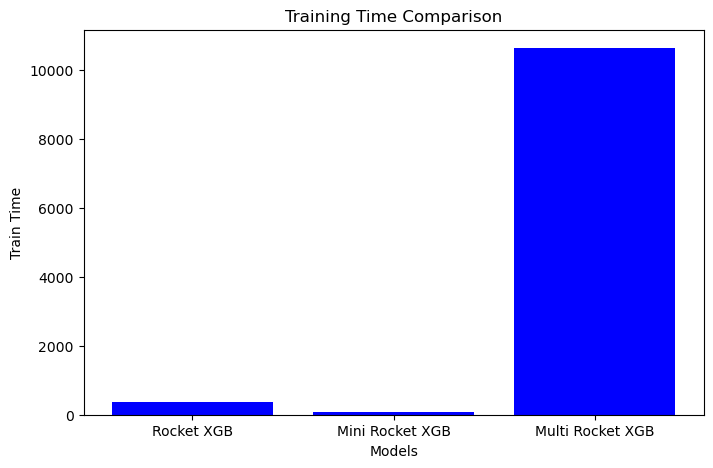

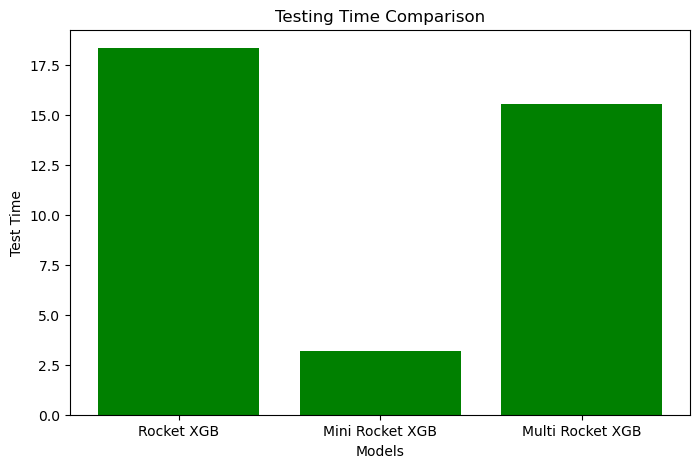

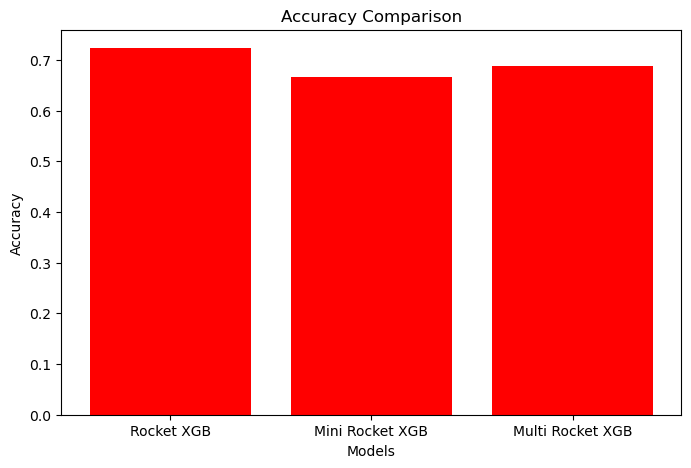

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Extract categories
models = ['Rocket XGB', 'Mini Rocket XGB', 'Multi Rocket XGB']

# Organizing data
train_times = [model_stats['rocket_xgb_train_time'], model_stats['mini_rocket_xgb_train_time'], model_stats['multi_rocket_xgb_train_time']]
test_times = [model_stats['rocket_xgb_test_time'], model_stats['mini_rocket_xgb_test_time'], model_stats['multi_rocket_xgb_test_time']]
accuracies = [model_stats['rocket_xgb_test_accuracy'], model_stats['mini_rocket_xgb_test_accuracy'], model_stats['multi_rocket_xgb_test_accuracy']]

# Plotting Train Time
plt.figure(figsize=(8, 5))
plt.bar(models, train_times, color='b')
plt.xlabel('Models')
plt.ylabel('Train Time')
plt.title('Training Time Comparison')
plt.show()

# Plotting Test Time
plt.figure(figsize=(8, 5))
plt.bar(models, test_times, color='g')
plt.xlabel('Models')
plt.ylabel('Test Time')
plt.title('Testing Time Comparison')
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color='r')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

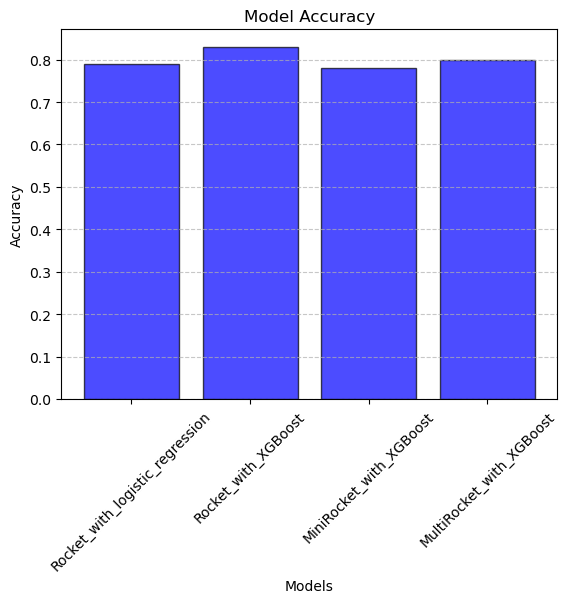

In [50]:
#  draw a bar graph of every models accuracy
import matplotlib.pyplot as plt

models = ['Rocket_with_logistic_regression', 'Rocket_with_XGBoost', 'MiniRocket_with_XGBoost', 'MultiRocket_with_XGBoost']

accuracies = [0.79,  0.83,0.78, 0.80]

plt.bar(models, accuracies, color='blue', alpha=0.7, edgecolor='black')
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()